### PSATITP

In [7]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from data_import import import_precipitation_ts, get_plants
from data_analysis import  is_stationary, plot_acf_pacf, precipitation_plots
from prediction import cross_validation, test
from split import split_train_test_by_size

### Importing data

In [8]:
ts_dict = import_precipitation_ts()
plant = "PSATIMBR"

### Data Analysis


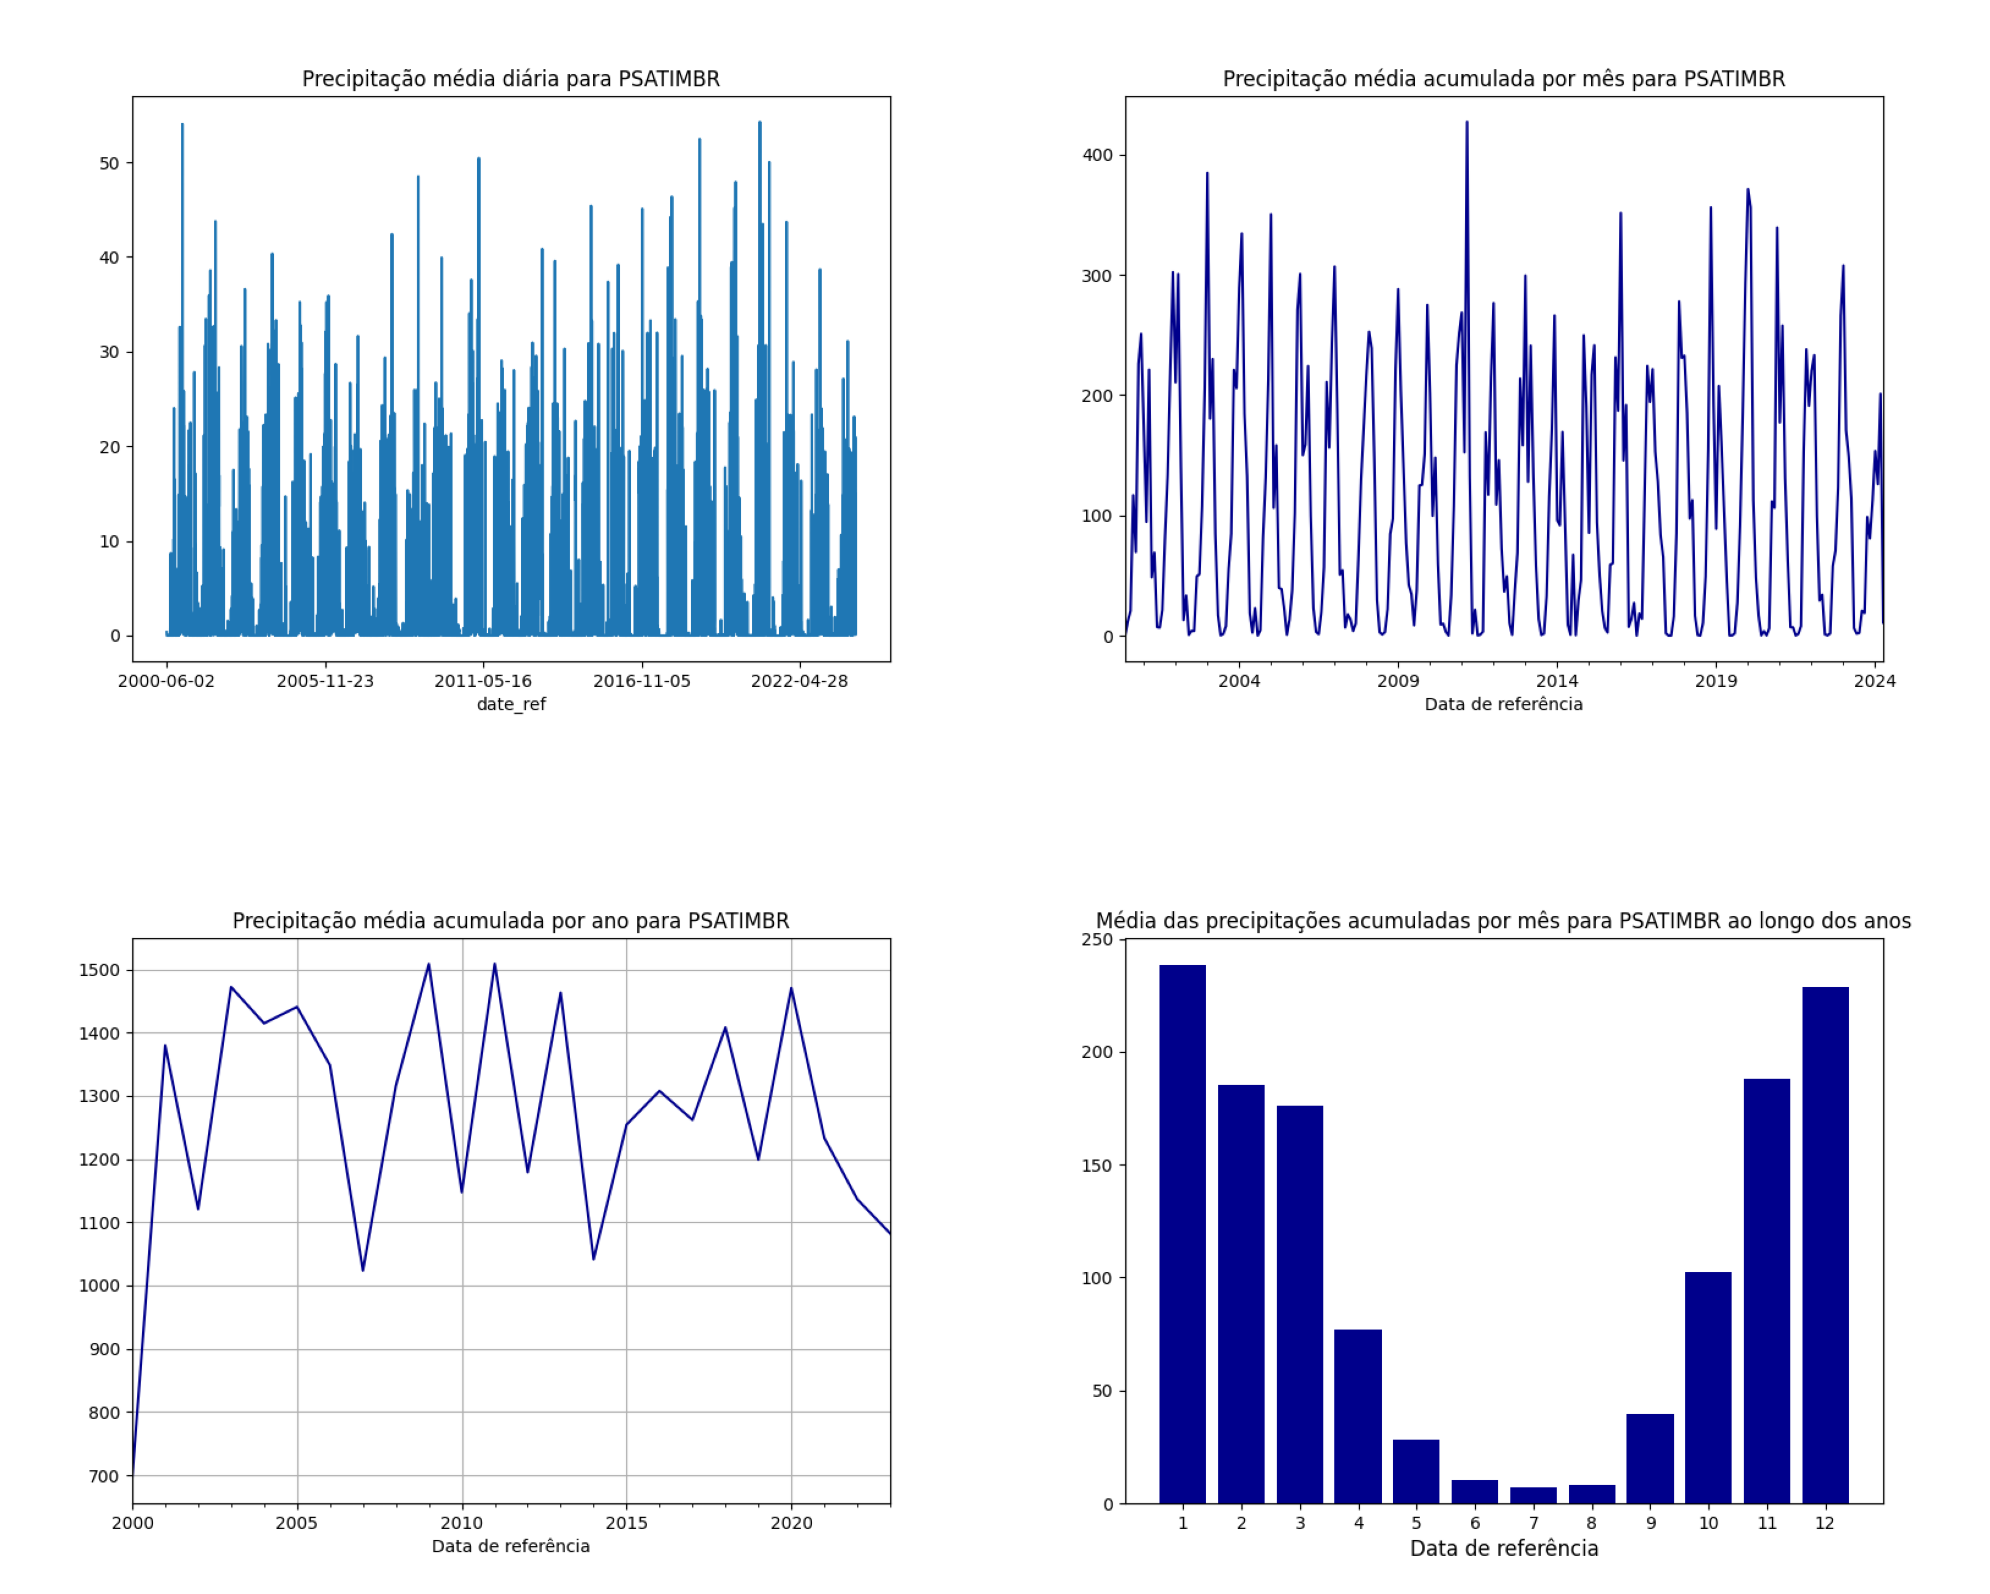

In [9]:
precipitation_plots(ts_dict, plant)

In [10]:
is_stationary(ts_dict, plant)

+---------------+------------+------------+------------+
|               |   Normal   |    Diff    |  LogDiff   |
+---------------+------------+------------+------------+
| ADF Statistic |   -8.17    |   -26.09   |   -21.73   |
|    p-value    |    0.00    |    0.00    |    0.00    |
|    result     | Stationary | Stationary | Stationary |
+---------------+------------+------------+------------+


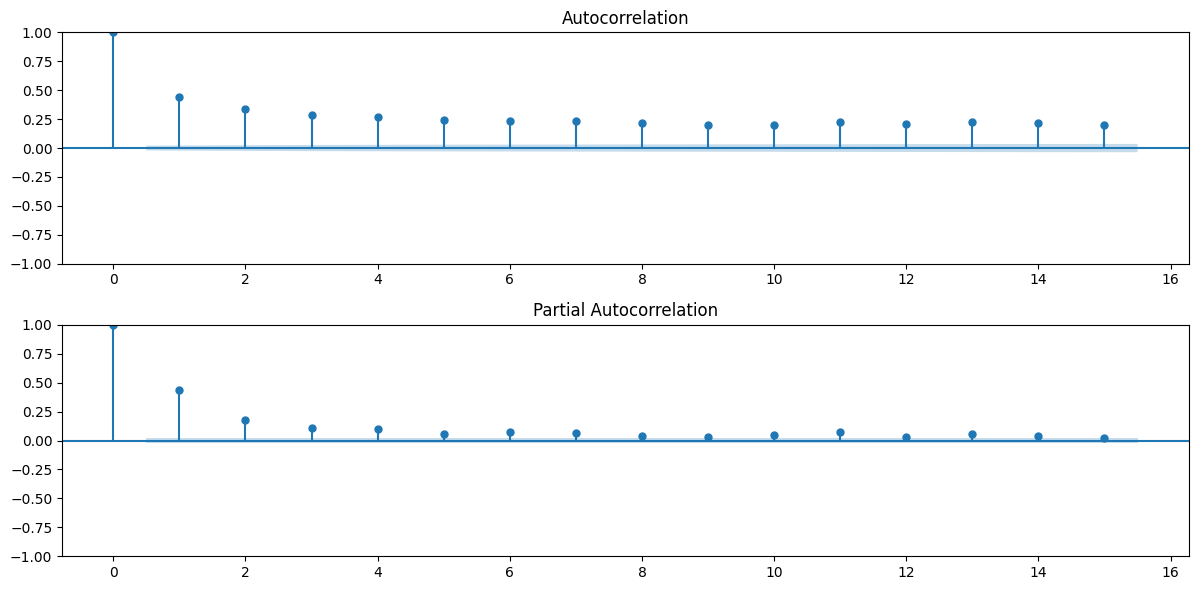

In [11]:
plot_acf_pacf(ts_dict, plant)

### Preparing Data for Prediction

In [12]:
data = ts_dict[plant].dropna(axis=0)
X_train, X_test, y_train, y_test = split_train_test_by_size(data, 100)

In [13]:
data_cg = data.copy()
c = pd.read_csv(f"../data/ts-{plant}-cfs-model.csv", index_col=[0])
g = pd.read_csv(f"../data/ts-{plant}-gefs-model.csv", index_col=[0])
data_cg = pd.concat([data_cg, c, g], axis=1).dropna(axis=0)
X_cg_train, X_cg_test, y_cg_train, y_cg_test = split_train_test_by_size(data_cg)

In [14]:
mask = np.ones(X_train.shape[1], dtype=bool)
mask[30:45] = False
X_train = X_train.loc[:, mask]
X_test = X_test.loc[:, mask]

### Hyperparameters search

In [15]:
tscv = TimeSeriesSplit(n_splits=5)

In [16]:
param_grid_knn = {
    'n_neighbors': range(1, 25),
    'p': [1, 2, 3],
}

grid_search_knn = GridSearchCV(KNeighborsRegressor(), param_grid_knn, cv=tscv, n_jobs=-1, verbose=1)
grid_search_knn.fit(X_train, y_train)
best_params_knn = grid_search_knn.best_params_
best_params_knn

Fitting 5 folds for each of 72 candidates, totalling 360 fits


{'n_neighbors': 24, 'p': 1}

In [17]:
param_grid_rf = {
    'n_estimators': [20, 50, 80, 100, 150, 200],
    'max_depth': [3, 4, 5, 6],
}

grid_search_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=tscv, n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train)
best_params_rf = grid_search_rf.best_params_
best_params_rf

Fitting 5 folds for each of 24 candidates, totalling 120 fits


{'max_depth': 4, 'n_estimators': 200}

In [18]:
grid_search_knn_cg = GridSearchCV(KNeighborsRegressor(), param_grid_knn, cv=tscv, n_jobs=-1, verbose=1)
grid_search_knn_cg.fit(X_cg_train, y_cg_train)
best_params_knn_cg = grid_search_knn_cg.best_params_
best_params_knn_cg

Fitting 5 folds for each of 72 candidates, totalling 360 fits


{'n_neighbors': 24, 'p': 1}

In [19]:
grid_search_rf_cg = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=tscv, n_jobs=-1, verbose=1)
grid_search_rf_cg.fit(X_cg_train, y_cg_train)
best_params_rf_cg = grid_search_rf_cg.best_params_
best_params_rf_cg

Fitting 5 folds for each of 24 candidates, totalling 120 fits


{'max_depth': 3, 'n_estimators': 200}

### Models

In [20]:
knn = KNeighborsRegressor(**best_params_knn)
rf = RandomForestRegressor(**best_params_rf, criterion="squared_error", random_state=0)

knn_cg = KNeighborsRegressor(**best_params_knn_cg)
rf_cg = RandomForestRegressor(**best_params_rf_cg, criterion="squared_error", random_state=0)


### Prediction without cfs and gefs

Evaluation 0:
+------------+------+------+
|            | Size | RMSE |
+------------+------+------+
|   Train    | 778  | 5.59 |
| Validation | 777  | 5.56 |
+------------+------+------+

Evaluation 1:
+------------+------+------+
|            | Size | RMSE |
+------------+------+------+
|   Train    | 1555 | 5.38 |
| Validation | 777  | 5.62 |
+------------+------+------+

Evaluation 2:
+------------+------+------+
|            | Size | RMSE |
+------------+------+------+
|   Train    | 2332 | 5.39 |
| Validation | 777  | 4.84 |
+------------+------+------+

Evaluation 3:
+------------+------+------+
|            | Size | RMSE |
+------------+------+------+
|   Train    | 3109 | 5.15 |
| Validation | 777  | 5.95 |
+------------+------+------+

Evaluation 4:
+------------+------+------+
|            | Size | RMSE |
+------------+------+------+
|   Train    | 3886 | 5.23 |
| Validation | 777  | 5.51 |
+------------+------+------+

Evaluation 5:
+------------+------+------+
|           

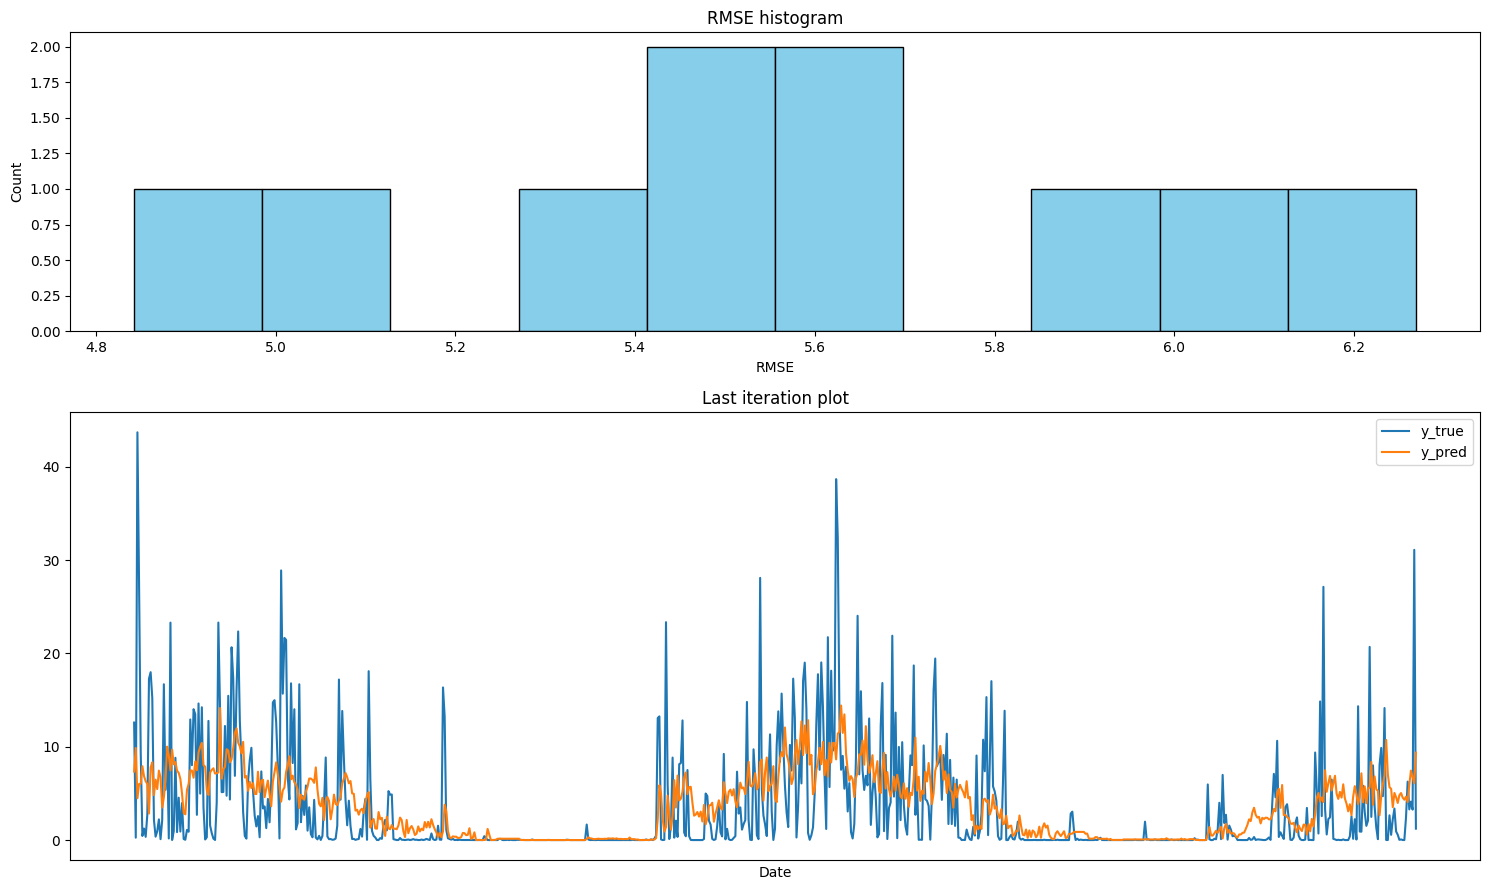

In [21]:
cross_validation(knn, X_train, y_train)

Evaluation 0:
+------------+------+------+
|            | Size | RMSE |
+------------+------+------+
|   Train    | 778  | 4.45 |
| Validation | 777  | 5.19 |
+------------+------+------+

Evaluation 1:
+------------+------+------+
|            | Size | RMSE |
+------------+------+------+
|   Train    | 1555 | 4.67 |
| Validation | 777  | 5.33 |
+------------+------+------+

Evaluation 2:
+------------+------+------+
|            | Size | RMSE |
+------------+------+------+
|   Train    | 2332 | 4.84 |
| Validation | 777  | 4.59 |
+------------+------+------+

Evaluation 3:
+------------+------+------+
|            | Size | RMSE |
+------------+------+------+
|   Train    | 3109 | 4.76 |
| Validation | 777  | 5.58 |
+------------+------+------+

Evaluation 4:
+------------+------+------+
|            | Size | RMSE |
+------------+------+------+
|   Train    | 3886 | 4.92 |
| Validation | 777  | 5.31 |
+------------+------+------+

Evaluation 5:
+------------+------+------+
|           

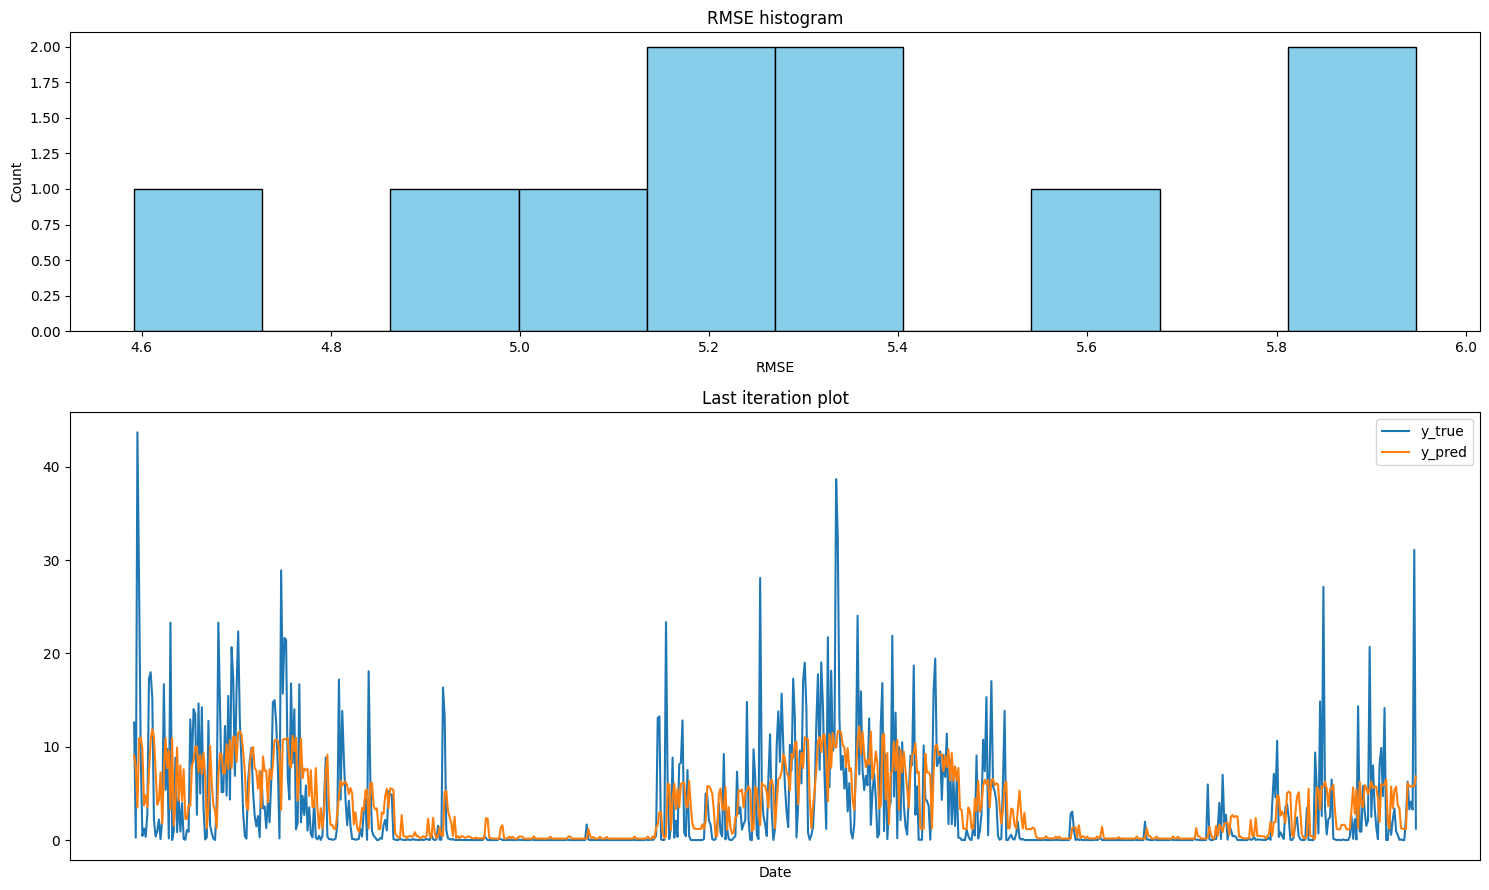

In [22]:
cross_validation(rf, X_train, y_train)

### Prediction with cfs and gefs

Evaluation 0:
+------------+------+------+
|            | Size | RMSE |
+------------+------+------+
|   Train    |  51  | 5.03 |
| Validation |  43  | 9.24 |
+------------+------+------+

Evaluation 1:
+------------+------+------+
|            | Size | RMSE |
+------------+------+------+
|   Train    |  94  | 6.56 |
| Validation |  43  | 5.92 |
+------------+------+------+

Evaluation 2:
+------------+------+------+
|            | Size | RMSE |
+------------+------+------+
|   Train    | 137  | 6.24 |
| Validation |  43  | 4.99 |
+------------+------+------+

Evaluation 3:
+------------+------+------+
|            | Size | RMSE |
+------------+------+------+
|   Train    | 180  | 5.80 |
| Validation |  43  | 2.34 |
+------------+------+------+

Evaluation 4:
+------------+------+------+
|            | Size | RMSE |
+------------+------+------+
|   Train    | 223  | 5.26 |
| Validation |  43  | 0.30 |
+------------+------+------+

Evaluation 5:
+------------+------+------+
|           

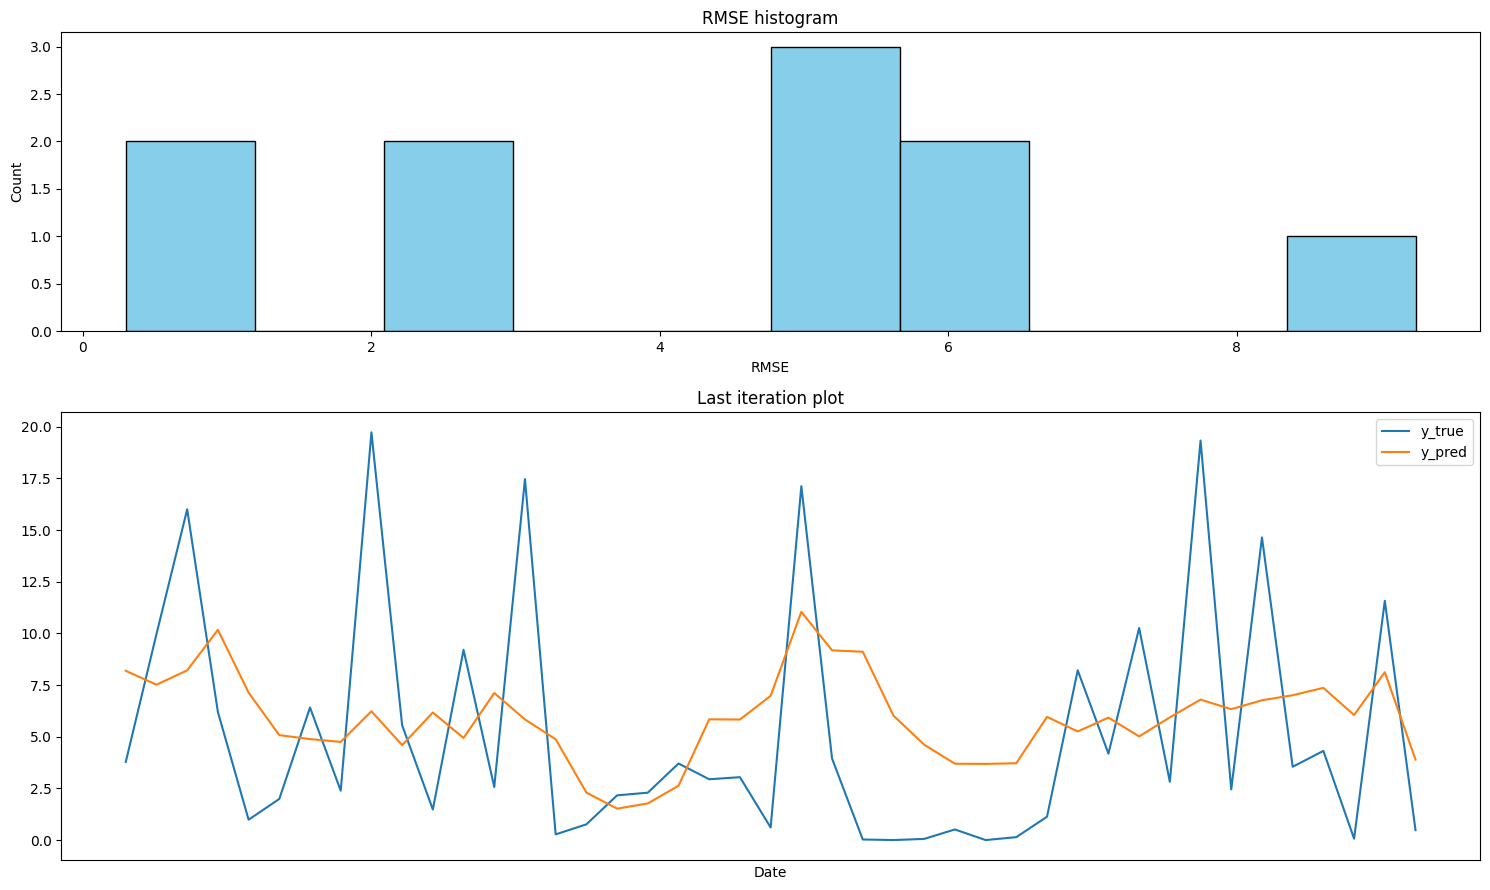

In [23]:
cross_validation(knn_cg, X_cg_train, y_cg_train)

Evaluation 0:
+------------+------+------+
|            | Size | RMSE |
+------------+------+------+
|   Train    |  51  | 2.35 |
| Validation |  43  | 8.57 |
+------------+------+------+

Evaluation 1:
+------------+------+------+
|            | Size | RMSE |
+------------+------+------+
|   Train    |  94  | 3.44 |
| Validation |  43  | 5.54 |
+------------+------+------+

Evaluation 2:
+------------+------+------+
|            | Size | RMSE |
+------------+------+------+
|   Train    | 137  | 3.76 |
| Validation |  43  | 4.26 |
+------------+------+------+

Evaluation 3:
+------------+------+------+
|            | Size | RMSE |
+------------+------+------+
|   Train    | 180  | 3.88 |
| Validation |  43  | 2.06 |
+------------+------+------+

Evaluation 4:
+------------+------+------+
|            | Size | RMSE |
+------------+------+------+
|   Train    | 223  | 3.59 |
| Validation |  43  | 0.94 |
+------------+------+------+

Evaluation 5:
+------------+------+------+
|           

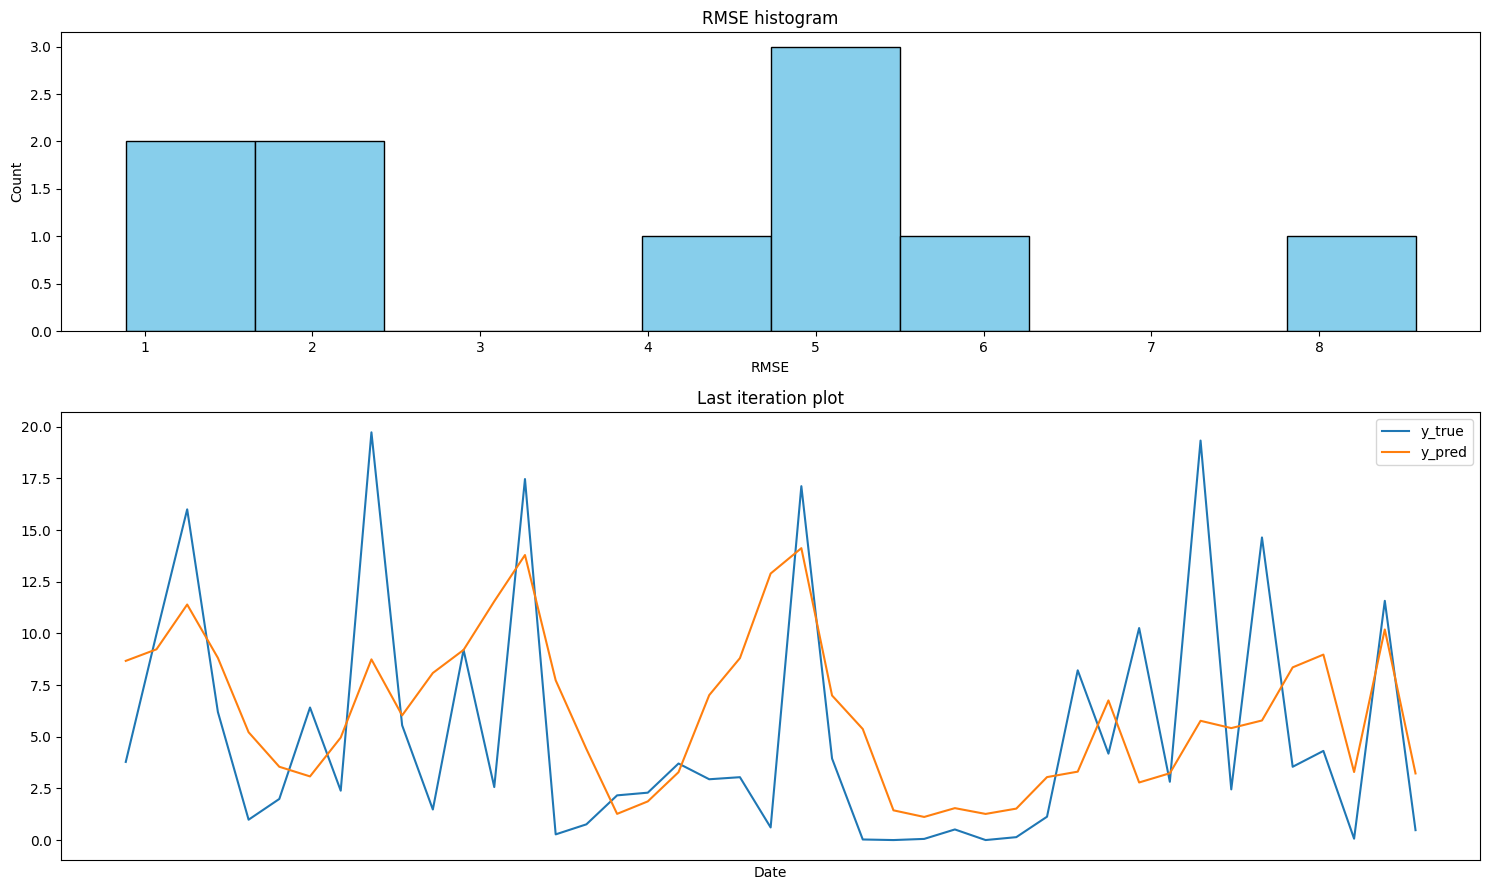

In [24]:
cross_validation(rf_cg, X_cg_train, y_cg_train)

### Test scores

#### Without cfs and gefs

In [25]:
test(knn, X_train, X_test, y_train, y_test)

Test RMSE: 5.68
Test  MAE: 4.41


In [26]:
test(rf, X_train, X_test, y_train, y_test)

Test RMSE: 5.48
Test  MAE: 4.20


In [27]:
test(xgb, X_train, X_test, y_train, y_test)

NameError: name 'xgb' is not defined

#### With cfs and gefs

In [ ]:
test(knn_cg, X_cg_train, X_cg_test, y_cg_train, y_cg_test)

In [ ]:
test(rf_cg, X_cg_train, X_cg_test, y_cg_train, y_cg_test)